In [1]:
import deepchem as dc
import torch
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
from sklearn.preprocessing import MultiLabelBinarizer
from deepchem.models.torch_models import MPNNModel
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('BST.csv',encoding = 'gb2312')

In [3]:
data

,Name,SMILES,Flavor type,Data resource,Label
0,Conessine hydrobromide,Br.Br.CC1C2CCC3C4CC=C5CC(N(C)C)CCC5(C)C4CCC32CN1C,Bitter,"BitterSweet, PlantMolecularTasteDB, BitterDB, ...",[1]
1,Arecoline hydrobromide,Br.COC(=O)C1=CCCN(C)C1,Bitter,"BitterSweet, BitterDB, ChemTasteDB",[1]
2,Avocadyne,C#CCCCCCCCCCCCC(O)CC(O)CO,Bitter,"PlantMolecularTasteDB, BitterDB, ChemTasteDB",[1]
3,"1-Acetoxy-2,4-dihydroxyheptadeca-16-yne",C#CCCCCCCCCCCCC(O)CC(O)COC(C)=O,Bitter,"BitterDB, ChemTasteDB",[1]
4,Hydrogen cyanide,C#N,Bitter,"BitterSweet, BitterDB, ChemTasteDB",[1]
...,...,...,...,...,...
13012,CNP0005404,O=C1N(CC2=NC=CC=C2)CC3N1CCN(CC=4C=CC=CC4)C3,Tasteless,Coconut,[3]
13013,CNP0005405,O=C1N(CC=2C=NC=CC2)CC3N1CCN(C3)C4CCOCC4,Tasteless,Coconut,[3]
13014,CNP0005406,O=C1N(C=2C=CC=CC2)CC3N1CCN(C3)C4CCN(C(=O)C)CC4,Tasteless,Coconut,[3]
13015,CNP0005407,O=C1N(C=2C=CC=CC2)CC3N1CCN(CC4=NC=CC=C4)C3,Tasteless,Coconut,[3]


In [4]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
features = featurizer.featurize(data['SMILES'])

In [5]:
dataset_y = [ast.literal_eval(label) for label in data['Label']]
dataset_new_y = MultiLabelBinarizer().fit_transform(dataset_y)

In [29]:
dataset = dc.data.NumpyDataset(X=features, y=dataset_new_y.astype(np.float64))

In [30]:
dataset.y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [31]:
splitter = dc.splits.RandomSplitter()#ScaffoldSplitter()
train_dataset,valid_dataset,test_dataset = splitter.train_valid_test_split(dataset=dataset,frac_train=0.7,frac_valid=0.1,frac_test=0.2,seed=100)

In [32]:
train_dataset.y

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [33]:
batch_size = 32
n_atom_feat = 70
n_pair_feat=8

In [39]:
model = dc.models.torch_models.MPNNModel(
    n_tasks=3,
    batch_size=batch_size,
    n_atom_feat=n_atom_feat,
    n_pair_feat=n_pair_feat,
    T=5,
    M=10,
    learning_rate=0.0001,
    use_queue=False,
    mode='classification')

In [40]:
loss = model.fit(train_dataset, nb_epoch=100)

In [41]:
loss

0.09089279174804688

# 验证集

In [42]:
y_pred_val = model.predict(valid_dataset)
y_pred_val = np.round(y_pred_val).astype(int)
y_pred_val = y_pred_val[:, :, 1]
y_pred_val

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [43]:
valid_dataset.y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [44]:
# 计算评估指标
val_f1 = f1_score(valid_dataset.y,y_pred_val, average='macro')
val_accuracy = accuracy_score(valid_dataset.y, y_pred_val)
val_recall = recall_score(valid_dataset.y, y_pred_val, average='macro')
val_precision = precision_score(valid_dataset.y, y_pred_val, average='macro')

# 输出评估指标
print('F1 score:', val_f1)
print('Accuracy:', val_accuracy)
print('Recall:', val_recall)
print('Precision:', val_precision)

F1 score: 0.8473452232052242
Accuracy: 0.8678955453149002
Recall: 0.8497859237482537
Precision: 0.8495774734845455


# 测试集

In [45]:
y_pred_test = model.predict(test_dataset)
y_pred_test = np.round(y_pred_test).astype(int)
y_pred_test = y_pred_test[:, :, 1]
y_pred_test

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [46]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_dataset.y, axis=1)
y_pred = np.argmax(y_pred_test, axis=1)

In [47]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [48]:
cm = confusion_matrix(y_true, y_pred)

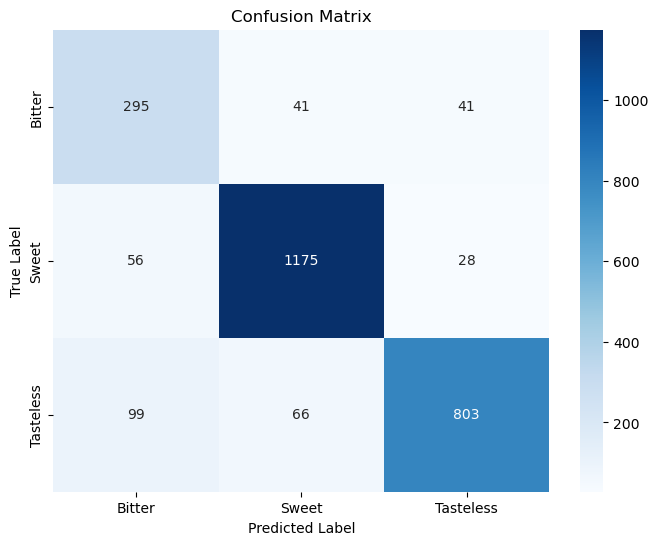

In [49]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [50]:
# 计算评估指标
test_f1 = f1_score(test_dataset.y,y_pred_test, average='macro')
test_accuracy = accuracy_score(test_dataset.y, y_pred_test)
test_recall = recall_score(test_dataset.y, y_pred_test, average='macro')
test_precision = precision_score(test_dataset.y, y_pred_test, average='macro')

# 输出评估指标
print('F1 score:', test_f1)
print('Accuracy:', test_accuracy)
print('Recall:', test_recall)
print('Precision:', test_precision)

F1 score: 0.842548865276138
Accuracy: 0.8648233486943164
Recall: 0.8337065578746791
Precision: 0.852789310763292
